In [2]:
import os
import pandas as pd
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

## Step 1: Data Preparation

In [3]:
# Function to load images from a directory
def load_images_from_directory(directory):
    X = []
    y = []
    for folder in os.listdir(directory):
        for file in os.listdir(os.path.join(directory, folder)):
            if file.endswith(".tif"):
                image_path = os.path.join(directory, folder, file)
                image = cv2.imread(image_path)
                if image is None:
                    continue
                if image.shape[0] >= 64:
                    image = cv2.resize(image, (64, 64))  # Resize image if necessary
                else:
                    print("image size: ", image.shape)
                    continue
                X.append(image)
                y.append(folder)
    return np.array(X), np.array(y)

# Load training and test sets
train_dir = 'train_set'
test_dir = 'test_set'

X_train, y_train = load_images_from_directory('H:\\Yehmh\\DNDF\\101_1_focus\\202404_101_seg_images_labeled_part\\train_set')
X_test, y_test = load_images_from_directory('H:\\Yehmh\\DNDF\\101_1_focus\\202404_101_seg_images_labeled_part\\test_set')

image size:  (61, 71, 3)


In [140]:
# import matplotlib.pyplot as plt

# for image in X:
#     plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
#     plt.axis('off')
#     plt.show()

In [ ]:
# Encode labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

## Step 3: Define transformations and create datasets

In [143]:
# transform = transforms.Compose([
#     transforms.ToTensor(),  # Convert image to PyTorch tensor
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize image data
# ])

# train_dataset = CustomDataset(X_train, y_train, transform=transform)
# test_dataset = CustomDataset(X_test, y_test, transform=transform)

In [144]:
# Data Augmentation ------

from PIL import Image

train_transform = transforms.Compose([
    transforms.Lambda(lambda x: Image.fromarray(x)),  # Convert NumPy array to PIL Image
    transforms.RandomHorizontalFlip(),  # Randomly flip the images horizontally
    transforms.RandomRotation(degrees=15),  # Randomly rotate the images by up to 15 degrees
    transforms.RandomCrop(size=(64, 64), padding=4),  # Randomly crop a 32x32 region of the image with padding
    transforms.ToTensor(),  # Convert image to PyTorch tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize image data
])

test_transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to PyTorch tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize image data
])

train_dataset = CustomDataset(X_train, y_train, transform=train_transform)
test_dataset = CustomDataset(X_test, y_test, transform=test_transform)

print(len(train_dataset), len(test_dataset))

34 9


## Step 4: Create data loaders

In [145]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# test_loader is created with shuffle=False. 
# Ensures that the evaluation process remains consistent across different evaluations 
# and that the model is tested on the same data distribution every time

## Step 5: Define the CNN model

In [146]:
print(image.shape)

(64, 64, 3)


In [147]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        # Define the convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)     # (in_channels (rgb), out_channels, filter_num, stride, padding), default stride = 1
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        # Define the fully connected layers
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        # self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Define the forward pass through the network
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv3(x))
        x = nn.functional.max_pool2d(x, 2)
        # x = x.view(-1, 64 * 16 * 16)
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x
        # return nn.functional.softmax(x, dim=1)  # Apply softmax activation for multi-class classification

## Step 6: Initialize model. loss function, and optimizer

In [148]:
model = CNN(num_classes=len(label_encoder.classes_))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [149]:
print(len(label_encoder.classes_))

6


## Step 7: Train the model

In [151]:
# num_epochs = 5000
# for epoch in range(num_epochs):
#     model.train()
#     for images, labels in train_loader:
#         # print("Batch Shape - Images:", images.shape)
#         # print("Batch Shape - Labels:", labels.shape)

#         optimizer.zero_grad()   # Zero the gradient
#         outputs = model(images) # Forward pass: computer predicted outputs
#         # print(outputs.shape)
#         loss = criterion(outputs, labels) # Compute the loss
#         loss.backward()     # Backward pass: compute gradient of the loss with respect to model parameters
#         optimizer.step()    # Update the model parameters based on the gradients

#     print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}")

Epoch [1/100], Loss: 1.7110869884490967, Accuracy: 0.08823529411764706
Epoch [2/100], Loss: 1.898968517780304, Accuracy: 0.4117647058823529
Epoch [3/100], Loss: 1.2939037084579468, Accuracy: 0.6176470588235294
Epoch [4/100], Loss: 1.527587890625, Accuracy: 0.2647058823529412
Epoch [5/100], Loss: 1.2973105311393738, Accuracy: 0.2647058823529412
Epoch [6/100], Loss: 1.7602949738502502, Accuracy: 0.2647058823529412
Epoch [7/100], Loss: 1.409416377544403, Accuracy: 0.29411764705882354
Epoch [8/100], Loss: 1.4882920384407043, Accuracy: 0.5294117647058824
Epoch [9/100], Loss: 1.3056774735450745, Accuracy: 0.6176470588235294
Epoch [10/100], Loss: 1.2511005401611328, Accuracy: 0.6176470588235294
Epoch [11/100], Loss: 1.6756499409675598, Accuracy: 0.5882352941176471
Epoch [12/100], Loss: 1.5899935960769653, Accuracy: 0.5882352941176471
Epoch [13/100], Loss: 1.9207634925842285, Accuracy: 0.6470588235294118
Epoch [14/100], Loss: 1.4218568205833435, Accuracy: 0.6470588235294118
Epoch [15/100], Los

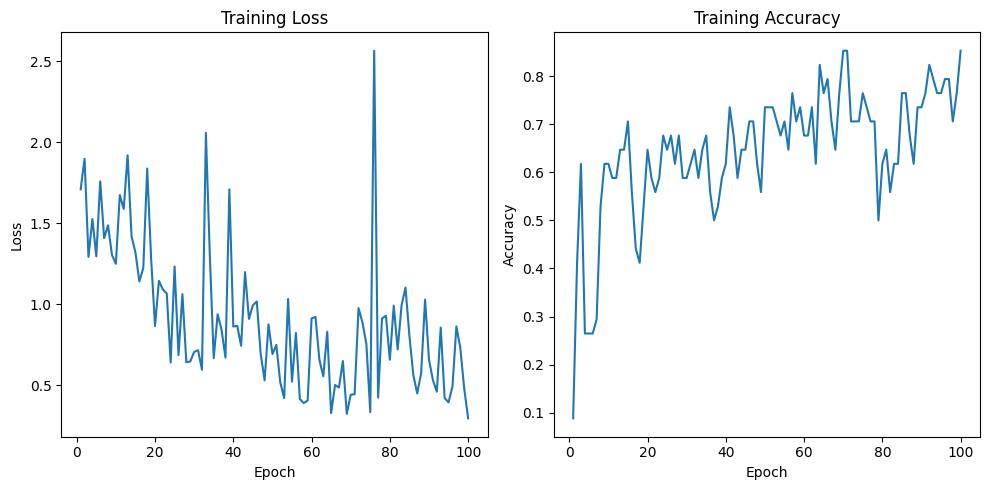

In [152]:
import matplotlib.pyplot as plt

num_epochs = 100
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    correct = 0
    total = 0
    epoch_loss = 0.0
    
    for images, labels in train_loader:
        optimizer.zero_grad()   # Zero the gradient
        outputs = model(images) # Forward pass: compute predicted outputs
        loss = criterion(outputs, labels) # Compute the loss
        loss.backward()     # Backward pass: compute gradient of the loss with respect to model parameters
        optimizer.step()    # Update the model parameters based on the gradients
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        epoch_loss += loss.item()

    train_accuracy = correct / total
    train_loss = epoch_loss / len(train_loader)
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {train_loss}, Accuracy: {train_accuracy}")

# Plotting
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')

plt.tight_layout()
plt.show()


## Step 8: Evaluate the model

In [153]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Print the predicted and actual labels
        for i in range(len(labels)):
            print("Predicted: {}, Actual: {}".format(predicted[i], labels[i]))

accuracy = correct / total
print('Test Accuracy: {:.2f}%'.format(100 * accuracy))

Predicted: 3, Actual: 0
Predicted: 4, Actual: 4
Predicted: 4, Actual: 4
Predicted: 3, Actual: 0
Predicted: 3, Actual: 0
Predicted: 3, Actual: 0
Predicted: 3, Actual: 3
Predicted: 2, Actual: 3
Predicted: 3, Actual: 3
Test Accuracy: 44.44%


## Classify Whole

In [154]:
# import os
# import cv2
# import torch
# import rasterio
# import numpy as np
# from torch.utils.data import DataLoader
# from torchvision import transforms
# # from your_model_file import CNN  # Import your CNN model class
# import csv

# # Function to extract coordinates from TIF files
# def extract_coordinates(tif_file):
#     with rasterio.open(tif_file) as src:
#         crs = src.crs
#         bounds = src.bounds
#         center_x = (bounds.left + bounds.right) / 2
#         center_y = (bounds.top + bounds.bottom) / 2
#         return crs, (center_x, center_y)

# # Define directory containing unknown TIF files
# # unknown_photos_dir = 'D:\\Yehmh\\test_py\\202301\\P00073_transect_234\\10m_10m\\unknown'

# def classify_and_write(unknown_photos_dir, output_csv_path):

#     # Initialize lists to store unknown photo paths, coordinates, and predictions
#     unknown_photos = []
#     unknown_coordinates = []

#     # Iterate over unknown TIF files
#     for filename in os.listdir(unknown_photos_dir):
#         if filename.endswith('.tif'):
#             tif_file = os.path.join(unknown_photos_dir, filename)
            
#             # Extract coordinates
#             crs, coordinates = extract_coordinates(tif_file)
            
#             # Append to the list
#             unknown_photos.append(tif_file)
#             unknown_coordinates.append((filename, crs, coordinates))

#     # Now you have a list of unknown photo paths (unknown_photos) and corresponding coordinates (unknown_coordinates)

#     # Load the trained model
#     # model = CNN(num_classes=len(label_encoder.classes_))
#     # model.load_state_dict(torch.load('path/to/your/trained/model.pth'))
#     model.eval()  # Set the model to evaluation mode

#     # Define transformations for the images
#     transform = transforms.Compose([
#         transforms.ToTensor(),  
#         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
#     ])

#     # Make predictions on the unknown photos
#     predictions = []
#     for photo_path in unknown_photos:
#         # Load and preprocess the image
#         image = cv2.imread(photo_path)
#         image = cv2.resize(image, (64, 64))  # Resize image if necessary
#         image = transform(image)
#         image = image.unsqueeze(0)  # Add batch dimension
        
#         # Perform inference
#         with torch.no_grad():
#             output = model(image)
#             predicted_class = torch.argmax(output).item()
#             predicted_label = label_encoder.classes_[predicted_class]
#             predictions.append(predicted_label)

#     # Now you have the predictions for each unknown photo in the list 'predictions'
#     # You can proceed to visualize the results on a map using the coordinates
#     with open(output_csv_path, 'w', newline='') as csvfile:
#         writer = csv.writer(csvfile)
#         writer.writerow(['Filename', 'Latitude', 'Longitude', 'Predicted Species'])  # Write header
#         for coord, label in zip(unknown_coordinates, predictions):
#             filename, crs, (latitude, longitude) = coord
#             writer.writerow([filename, latitude, longitude, label])

In [155]:
# import csv

# # Define output CSV file path
# # output_csv_path = 'D:/Yehmh/test_py/202301/P00073_transect_234/10m_10m/species_distribution.csv'


# # Write results to CSV file
# with open(output_csv_path, 'w', newline='') as csvfile:
#     writer = csv.writer(csvfile)
#     writer.writerow(['Filename', 'Latitude', 'Longitude', 'Predicted Species'])  # Write header
#     for coord, label in zip(unknown_coordinates, predictions):
#         filename, crs, (latitude, longitude) = coord
#         writer.writerow([filename, latitude, longitude, label])


In [156]:
# list = [69, 70, 71, 75, 76, 78, 79, 82]

# for i in list:
#     unknown_photos_dir = f'D:\\Yehmh\\test_py\\202301\\P000{i}\\5m_5m'
#     output_csv_path = f'D:/Yehmh/test_py/202301/P000{i}_species_distribution.csv'
    
#     classify_and_write(unknown_photos_dir, output_csv_path)
    
#     print(i, " done")

### add probabilities

In [157]:
import os
import cv2
import torch
import rasterio
import numpy as np
from torch.utils.data import DataLoader
from torchvision import transforms
# from your_model_file import CNN  # Import your CNN model class
import csv

# Function to extract coordinates from TIF files
def extract_coordinates(tif_file):
    with rasterio.open(tif_file) as src:
        crs = src.crs
        bounds = src.bounds
        center_x = (bounds.left + bounds.right) / 2
        center_y = (bounds.top + bounds.bottom) / 2
        return crs, (center_x, center_y)

# Define directory containing unknown TIF files
# unknown_photos_dir = 'D:\\Yehmh\\test_py\\202301\\P00073_transect_234\\10m_10m\\unknown_cleaned'

def classify_and_write(unknown_photos_dir, output_csv_path):

    # Initialize lists to store unknown photo paths, coordinates, and predictions
    unknown_photos = []
    unknown_coordinates = []

    # Iterate over unknown TIF files
    for filename in os.listdir(unknown_photos_dir):
        if filename.endswith('.tif'):
            tif_file = os.path.join(unknown_photos_dir, filename)
            
            # Extract coordinates
            crs, coordinates = extract_coordinates(tif_file)
            
            # Append to the list
            unknown_photos.append(tif_file)
            unknown_coordinates.append((filename, crs, coordinates))

    # Now you have a list of unknown photo paths (unknown_photos) and corresponding coordinates (unknown_coordinates)

    # Define a function to classify with threshold
    def classify_with_threshold(probabilities, threshold):
        max_prob, max_index = torch.max(probabilities, dim=1)
        if max_prob.item() < threshold:
            return "unknown"
        else:
            predicted_label = label_encoder.classes_[max_index.item()]
            return predicted_label  # Return the index of the class with the maximum probability


    # Load the trained model
    # model = CNN(num_classes=len(label_encoder.classes_))
    # model.load_state_dict(torch.load('path/to/your/trained/model.pth'))
    model.eval()  # Set the model to evaluation mode

    # Define transformations for the images
    transform = transforms.Compose([
        transforms.ToTensor(),  
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
    ])

    # Make predictions on the unknown photos
    predictions = []
    for photo_path in unknown_photos:
        # Load and preprocess the image
        image = cv2.imread(photo_path)
        image = cv2.resize(image, (64, 64))  # Resize image if necessary
        image = transform(image)
        image = image.unsqueeze(0)  # Add batch dimension
        
        # Perform inference
        with torch.no_grad():
            output = model(image)
            probabilities = nn.functional.softmax(output, dim=1)  # Apply softmax to get probabilities
            classification = classify_with_threshold(probabilities, threshold=0.7)  # Adjust threshold as needed
            predictions.append(classification)

    # Now you have the predictions for each unknown photo in the list 'predictions'
    # You can proceed to visualize the results on a map using the coordinates
    with open(output_csv_path, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Filename', 'Latitude', 'Longitude', 'Predicted Species'])  # Write header
        for coord, label in zip(unknown_coordinates, predictions):
            filename, crs, (latitude, longitude) = coord
            writer.writerow([filename, latitude, longitude, label])

In [158]:
# import csv

# # Define output CSV file path
# output_csv_path = 'D:/Yehmh/test_py/202301/P00073_transect_234/10m_10m/species_distribution_unclassified_2.csv'

# # Write results to CSV file
# with open(output_csv_path, 'w', newline='') as csvfile:
#     writer = csv.writer(csvfile)
#     writer.writerow(['Filename', 'Latitude', 'Longitude', 'Predicted Species'])  # Write header
#     for coord, label in zip(unknown_coordinates, predictions):
#         filename, crs, (latitude, longitude) = coord
#         writer.writerow([filename, latitude, longitude, label])

In [159]:
unknown_photos_dir = 'h:\\Yehmh\\DNDF\\101_1_focus\\202404_101_seg_images'
output_csv_path = 'h:\\Yehmh\\DNDF\\101_1_focus\\20240626_CNN_prob.csv'
classify_and_write(unknown_photos_dir, output_csv_path)
print("done 1")

done 1
